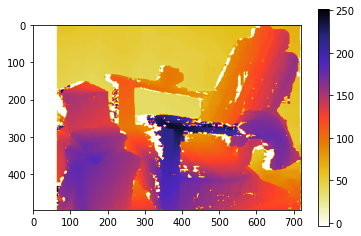

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [ ]:

#Given from Adirondack-perfect/calib.txt
# Load the left and right images in grayscale
left_image = cv2.imread('Adirondack-perfect/im0.png', 0)  
right_image = cv2.imread('Adirondack-perfect/im1.png', 0)  

# Downsample the images by a factor of 0.25
factor = 0.25
left_image_downsampled = cv2.resize(left_image, None, fx=factor, fy=factor, interpolation=cv2.INTER_AREA)
right_image_downsampled = cv2.resize(right_image, None, fx=factor, fy=factor, interpolation=cv2.INTER_AREA)

# Initialize the stereo block matching object
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=64,  # Adjust if necessary
    blockSize=5,
    P1=8 * 5**2,
    P2=32 * 5**2,
    disp12MaxDiff=10,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Compute the disparity map on the downsampled images
disparity_map_downsampled = stereo.compute(left_image_downsampled, right_image_downsampled).astype(np.float32) / 16.0

# Scale the disparity map values back up to match the original image scale
disparity_map_scaled = disparity_map_downsampled * (1 / factor)  # Multiply by the inverse of the downscale factor

In [ ]:
# Save and/or display the disparity map
cv2.imwrite('disparity_map_scaled.png', disparity_map_scaled)
plt.imshow(disparity_map_scaled, cmap='CMRmap_r')
plt.colorbar()
plt.show()

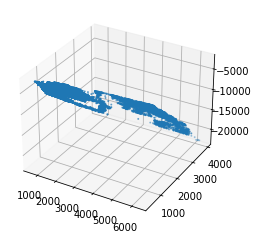

In [3]:
# Intrinsic parameters of the camera
focal_length = 4161.221  # Assuming the focal length is the same in x and y directions
cx = 1445.577  # The x-coordinate of the principal point
cy = 984.686  # The y-coordinate of the principal point
baseline = 176.252  # The distance between the two camera centers

# Creating the Q matrix for reprojecting
Q = np.float32([
    [1, 0, 0, -cx],
    [0, 1, 0, -cy],
    [0, 0, 0, focal_length],
    [0, 0, -1/baseline, 0]
])

# Reproject the points to 3D
points_3D = cv2.reprojectImageTo3D(disparity_map_scaled, Q)

# Reshape the points to a 2D array where each row is a point
points = points_3D.reshape(-1, 3)

# Filter out points with a disparity of 0 (indicating no measurement)
mask_map = disparity_map_scaled > disparity_map_scaled.min()
filtered_points = points[mask_map.ravel()]

# Now, filtered_points contains the 3D coordinates of each pixel
downsample_rate = 15  # Keep one in every 'downsample_rate' points
downsampled_points = filtered_points[::downsample_rate]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(downsampled_points[:, 0], downsampled_points[:, 1], downsampled_points[:, 2], s=1)
plt.show()